Q. Dense Block: Develop a CNN architecture based on dense blocks, as introduced in the DenseNet model. Train the CNN on the CIFAR100 dataset and conduct a comprehensive evaluation of its classification accuracy, precision, recall,f1score. The network should have at least 3 convolutional blocks. (each block having depthwise convolution followed by pointwise convolution).connection Evaluate the model's performance with and without the dense connection.

#Import library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional


In [2]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Data processing

In [3]:

training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 169001437/169001437 [00:02<00:00, 65081880.65it/s] 


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [4]:
training_data


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
type(training_data)

torchvision.datasets.cifar.CIFAR100

In [6]:
len(training_data.classes)

100

Train data split into training and validation

In [7]:
train_size=int(len(training_data)*0.8)
val_size=len(training_data)-train_size

In [8]:
train_data,validation_data=random_split(training_data,[train_size,val_size])

In [9]:
train_data

In [10]:
#data loading
batch_size=32

In [11]:
train_loader=DataLoader(train_data,batch_size,shuffle=True)
validaton_loader=DataLoader(validation_data,batch_size)
test_loader=DataLoader(test_data,batch_size)

#Dense model building

In [12]:
class DenseNet(nn.Module):
    def __init__(self, in_channels, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(self._make_conv(in_channels + i*100))##concatenate layes

    def _make_conv(self, in_channels):#helper function to convolute

        # return nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        return (nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding =1, groups=in_channels),
            nn.Conv2d(in_channels, 100, kernel_size=1),
            nn.BatchNorm2d(num_features= 100),
        ))

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(x)
            x = torch.cat((output,x), dim = 1)

        output = output.reshape(output.shape[0], -1)
        return output


In [14]:
# Initialize DenseNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet(3, 4).to(device)

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#training the model with dense block

In [16]:

#training layer 1
train_losses = []
epochs=10
for epoch in range(epochs):

    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape(outputs.shape[0],-1), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in validaton_loader:
            inputs = inputs.to(device) #to use gpu
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.reshape(outputs.shape[0],-1), labels)#reshape
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(validaton_loader)
    accuracy = correct_predictions / total_samples


    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}')
    print(f'Validation Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.3f}%')







Epoch [1/10], Loss: 5.0987
Validation Loss: 5.0987, Accuracy: 1.380%
Epoch [2/10], Loss: 4.6466
Validation Loss: 4.6466, Accuracy: 1.940%
Epoch [3/10], Loss: 4.6748
Validation Loss: 4.6748, Accuracy: 2.070%
Epoch [4/10], Loss: 4.6460
Validation Loss: 4.6460, Accuracy: 1.840%
Epoch [5/10], Loss: 4.6054
Validation Loss: 4.6054, Accuracy: 2.190%
Epoch [6/10], Loss: 4.6164
Validation Loss: 4.6164, Accuracy: 1.840%
Epoch [7/10], Loss: 4.6067
Validation Loss: 4.6067, Accuracy: 2.030%
Epoch [8/10], Loss: 4.5996
Validation Loss: 4.5996, Accuracy: 2.200%
Epoch [9/10], Loss: 4.6036
Validation Loss: 4.6036, Accuracy: 2.140%
Epoch [10/10], Loss: 4.5963
Validation Loss: 4.5963, Accuracy: 2.480%


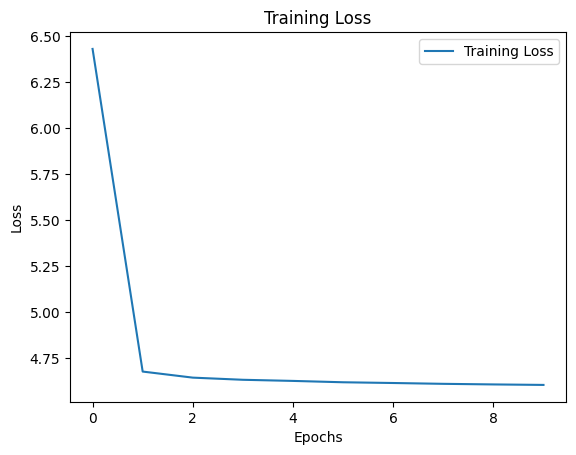

In [17]:
# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

Evaluate the model with dense block

In [28]:
model.eval()

# Evaluate the model on the test set
correct = 0
total = 0
predictions = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        y_true.extend(labels.cpu().numpy())  # Assuming labels are tensors, convert to numpy array

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())  # Append predictions
accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.4f}%')

Test Accuracy: 1.8900%


#Normal cnn

In [19]:
# normal cnn
class cnn(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.layer=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),padding=(1,1),stride=(1,1)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.AdaptiveAvgPool2d((10,10))##AdaptiveAvgPool2d change output to 10*10 matrix with variable channel

    )
  def forward(self,x):
    x=self.layer1(x)
    x=self.layer2(x)

    return x

In [20]:
model1=cnn(3,16).to(device)

In [21]:
#training layer 1
train_losses = []
epochs=10
for epoch in range(epochs):

    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape(outputs.shape[0],-1), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in validaton_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.reshape(outputs.shape[0],-1), labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(validaton_loader)
    accuracy = correct_predictions / total_samples


    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}')
    print(f'Validation Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.3f}%')




Epoch [1/10], Loss: 4.5940
Validation Loss: 4.5940, Accuracy: 2.330%
Epoch [2/10], Loss: 4.5883
Validation Loss: 4.5883, Accuracy: 2.250%
Epoch [3/10], Loss: 4.6029
Validation Loss: 4.6029, Accuracy: 2.030%
Epoch [4/10], Loss: 4.6162
Validation Loss: 4.6162, Accuracy: 2.130%
Epoch [5/10], Loss: 4.6112
Validation Loss: 4.6112, Accuracy: 2.090%
Epoch [6/10], Loss: 4.5873
Validation Loss: 4.5873, Accuracy: 2.180%
Epoch [7/10], Loss: 4.6061
Validation Loss: 4.6061, Accuracy: 1.780%
Epoch [8/10], Loss: 4.5975
Validation Loss: 4.5975, Accuracy: 2.250%
Epoch [9/10], Loss: 4.5836
Validation Loss: 4.5836, Accuracy: 2.190%
Epoch [10/10], Loss: 4.5850
Validation Loss: 4.5850, Accuracy: 1.960%


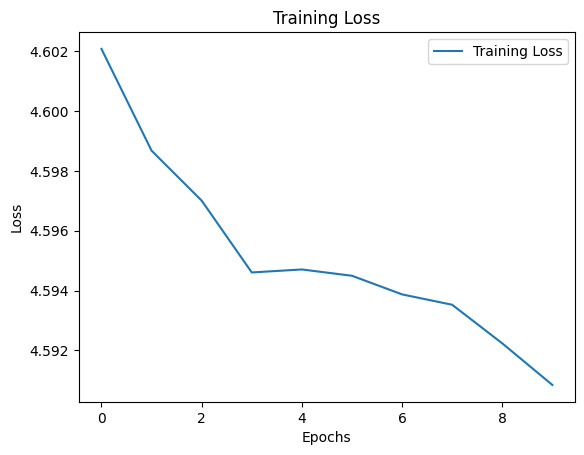

In [22]:
# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [29]:
model.eval()

# Evaluate the model on the test set
correct = 0
total = 0
predictions1 = []
y_true1=[]  #help to get report
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        y_true1.extend(labels.cpu().numpy())  # Assuming labels are tensors, convert to numpy array

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions1.extend(predicted.cpu().numpy())  # Append predictions
accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.4f}%')

Test Accuracy: 1.8900%


#comparision

In [31]:
from sklearn.metrics import classification_report
import numpy as np
# Evaluate the models
# Convert predictions to numpy arrays
y_pred_dense = np.array(predictions)
y_pred_no_dense = np.array(predictions1)
y_true = np.array(y_true)
y_true1 = np.array(y_true1)

# print("Metrics for DenseNet with dense connections:")
# print(classification_report(y_true,predictions))

# print("Metrics for DenseNet without dense connections:")
# print(classification_report(y_true1, predictions1))

In [32]:
#it will classification reports
report_dense = classification_report(y_true, predictions, output_dict=True)
report_no_dense = classification_report(y_true1,predictions1, output_dict=True)

# Extract metrics
precision_dense = report_dense['weighted avg']['precision']
recall_dense = report_dense['weighted avg']['recall']
f1_score_dense = report_dense['weighted avg']['f1-score']

precision_no_dense = report_no_dense['weighted avg']['precision']
recall_no_dense = report_no_dense['weighted avg']['recall']
f1_score_no_dense = report_no_dense['weighted avg']['f1-score']

# Print metrics
print("Metrics for DenseNet with dense connections:")
print("Precision:", precision_dense)
print("Recall:", recall_dense)
print("F1-score:", f1_score_dense)

print("\nMetrics for DenseNet without dense connections:")
print("Precision:", precision_no_dense)
print("Recall:", recall_no_dense)
print("F1-score:", f1_score_no_dense)

Metrics for DenseNet with dense connections:
Precision: 0.009760936625769693
Recall: 0.0189
F1-score: 0.004194917333273332

Metrics for DenseNet without dense connections:
Precision: 0.009760936625769693
Recall: 0.0189
F1-score: 0.004194917333273332


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif